In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# MobileNetV2 için ön işleme fonksiyonu
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 258s 902ms/step - accuracy: 0.7026 - loss: 0.8895 - val_accuracy: 0.8550 - val_loss: 0.4554
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 856ms/step - accuracy: 0.8347 - loss: 0.4781 - val_accuracy: 0.8534 - val_loss: 0.4401
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 857ms/step - accuracy: 0.8411 - loss: 0.4413 - val_accuracy: 0.8609 - val_loss: 0.3948
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 853ms/step - accuracy: 0.8405 - loss: 0.4302 - val_accuracy: 0.8582 - val_loss: 0.3795
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 855ms/step - accuracy: 0.8500 - loss: 0.4113 - val_accuracy: 0.8673 - val_loss: 0.3842
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 855ms/step - accuracy: 0.8508 - loss: 0.4076 - val_accuracy: 0.8627 - val_loss: 0.3782
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 856ms/step - accuracy: 0.8542 - loss: 0.4050 - val_accuracy: 0.8679 - val_loss: 0.3755
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 854ms/step - accuracy: 

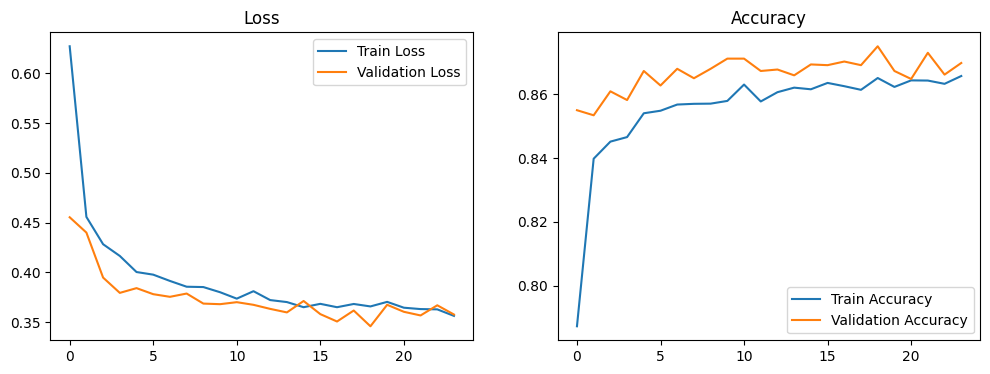

In [4]:
# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [5]:
# Test veri seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8621 - loss: 0.3466
Test Loss: 0.3459
Test Accuracy: 0.8750


Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: C
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/C/aug_0_2503.jpg


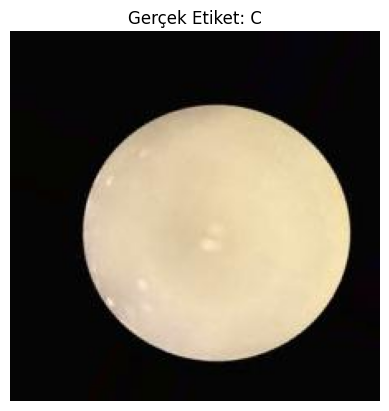

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Gerçek Etiket: C
Tahmin Edilen Etiket: C
Tahmin Olasılıkları: [4.1486472e-03 8.4076118e-01 5.0786776e-03 1.0847632e-02 3.9237173e-04
 8.8806977e-05 4.6199270e-02 9.2483394e-02]


In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

Attention

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 251s 879ms/step - accuracy: 0.7189 - loss: 0.8415 - val_accuracy: 0.8607 - val_loss: 0.4327
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 234s 852ms/step - accuracy: 0.8526 - loss: 0.4181 - val_accuracy: 0.8604 - val_loss: 0.3900
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 234s 851ms/step - accuracy: 0.8565 - loss: 0.3858 - val_accuracy: 0.8582 - val_loss: 0.4049
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 855ms/step - accuracy: 0.8598 - loss: 0.3835 - val_accuracy: 0.8638 - val_loss: 0.3813
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 853ms/step - accuracy: 0.8585 - loss: 0.3781 - val_accuracy: 0.8702 - val_loss: 0.3630
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 234s 850ms/step - accuracy: 0.8676 - loss: 0.3599 - val_accuracy: 0.8636 - val_loss: 0.3700
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 234s 851ms/step - accuracy: 0.8671 - loss: 0.3635 - val_accuracy: 0.8443 - val_loss: 0.3961
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 235s 852ms/step - accuracy: 

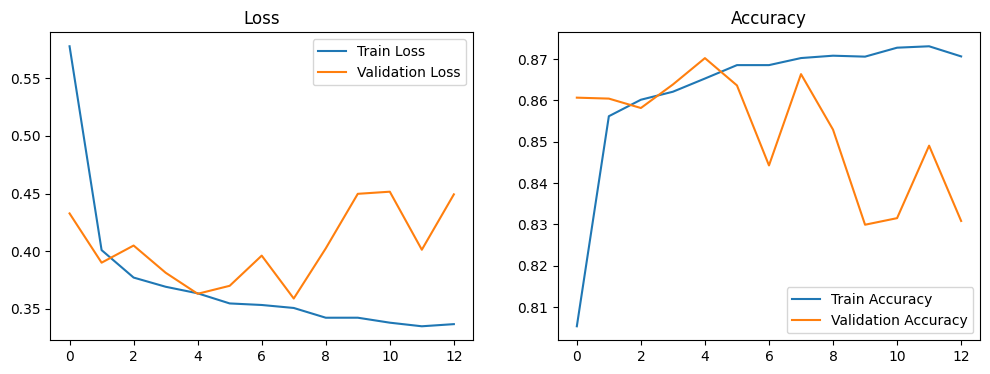

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Add, Conv2D, Activation, Reshape

# Channel Attention Modülü
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.gap = GlobalAveragePooling2D()
        self.dense1 = None
        self.dense2 = None

    def build(self, input_shape):
        # Giriş şekline göre Dense katmanlarını oluştur
        channels = input_shape[-1]
        self.dense1 = Dense(units=int(channels / self.ratio), activation='relu')
        self.dense2 = Dense(units=channels, activation='sigmoid')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling
        gap = self.gap(inputs)
        # Dense layers
        fc1 = self.dense1(gap)
        fc2 = self.dense2(fc1)
        # Reshape to match input dimensions
        fc2 = Reshape((1, 1, fc2.shape[1]))(fc2)
        # Multiply with input
        return Multiply()([inputs, fc2])

# Spatial Attention Modülü
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(filters=1, kernel_size=self.kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Average pooling and max pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        # Concatenate and apply convolution
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        # Multiply with input
        return Multiply()([inputs, attention])

# MobileNetV2 Modeline Attention Mekanizmalarını Ekleme
from tensorflow.keras.applications import MobileNetV2

# MobileNetV2 modelini yükle
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)

# Channel Attention ekle
x = ChannelAttention()(x)

# Spatial Attention ekle
x = SpatialAttention()(x)

# Global Average Pooling ve diğer katmanlar
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)

# Modeli oluştur
model = tf.keras.Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_attention_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100

# Modeli eğit
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

# Eğitim ve doğrulama kaybını ve doğruluğunu çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()